In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# Explore Data

In [2]:
df = pd.read_csv('./GSE150150_raw_counts.csv')

In [3]:
columns = ["Trunk E9.5", "Trunk E10.5", "DRG E9.5", "DRG E10.5", "DRG E11.5", "DRG E12.5", "Cranio E12.5"]
idMappings = {
    "SS2_15_0085": "Trunk E9.5",
    "SS2_18_107": "Trunk E10.5",
    "SS2_18_108": "Trunk E10.5",
    "SS2_18_109": "Trunk E10.5",
    "SS2_16_767": "DRG E9.5",
    "SS2_17_435": "DRG E9.5",
    "SS2_16_688": "DRG E10.5",
    "SS2_16_769": "DRG E10.5",
    "SS2_17_432": "DRG E10.5",
    "SS2_17_433": "DRG E10.5",
    "SS2_16_385": "DRG E11.5",
    "SS2_16_384": "DRG E12.5",
    "SS2_15_0073": "Cranio E12.5",
    "SS2_15_0169": "Cranio E12.5"
}

In [4]:
print("Gene Count: ", len(df))
sampleRow = df.sample()
print("Sample Row: ", sampleRow)
print("Sample Gene: ", sampleRow.iloc[0,0])

Gene Count:  24582
Sample Row:          Gene  SS2_15_0073:A9_unique.bam  SS2_15_0073:A8_unique.bam  \
2350  Hoxd12                          0                          0   

      SS2_15_0073:A7_unique.bam  SS2_15_0073:A6_unique.bam  \
2350                          0                          0   

      SS2_15_0073:A5_unique.bam  SS2_15_0073:A4_unique.bam  \
2350                          0                          0   

      SS2_15_0073:A3_unique.bam  SS2_15_0073:A2_unique.bam  \
2350                          0                          0   

      SS2_15_0073:A10_unique.bam  ...  SS2_15_0085:P15_unique.bam  \
2350                           0  ...                           0   

      SS2_15_0085:P16_unique.bam  SS2_15_0085:P17_unique.bam  \
2350                           0                           0   

      SS2_15_0085:P18_unique.bam  SS2_15_0085:P19_unique.bam  \
2350                           0                           0   

      SS2_15_0085:P20_unique.bam  SS2_15_0085:P24_uniqu

In [5]:
import numbers
df.columns = [idMappings[col.split(":")[0]] if col.split(":")[0] in idMappings else col for col in df.columns]
dfParsed = df.groupby(df.columns, axis=1).apply(lambda x: x.mean(axis=1) if isinstance(x.iloc[0,0], numbers.Number) else x.iloc[:,0])
dfParsed = dfParsed[dfParsed.columns[5:].tolist() + dfParsed.columns[:5].tolist()]

print("Grouped Gene Count: ", len(dfParsed))
sampleRow = dfParsed.sample()
print("Grouped Sample Row: ", sampleRow)
print("Grouped Sample Gene: ", sampleRow.iloc[0,0])

Grouped Gene Count:  24582
Grouped Sample Row:          Gene  Trunk E10.5  Trunk E9.5  Cranio E12.5  DRG E10.5  DRG E11.5  \
2381  Zc3h15    29.746528   58.578125     42.153646  47.266927  51.109375   

      DRG E12.5   DRG E9.5  
2381  46.841146  54.032552  
Grouped Sample Gene:  Zc3h15


### Other Trials

In [6]:
# Single column of data
singleCellData = df.iloc[:,10:13] # 10 and 11th column, random
print(singleCellData)

       Cranio E12.5  Cranio E12.5  Cranio E12.5
0               950          5505          3516
1               570          1752          1197
2               104          1148           491
3               200           886           431
4                 2             0             0
...             ...           ...           ...
24577             0             0             0
24578             0             0             0
24579             0             0             0
24580             0             0             0
24581             0             0             0

[24582 rows x 3 columns]


In [7]:
# Normalized data (Log Transformation)
from sklearn.preprocessing import StandardScaler

dfWithoutGene = dfParsed.iloc[:, 1:]

scaler = StandardScaler()
scaler.fit(dfWithoutGene)
normalizedDf = scaler.transform(dfWithoutGene)
normalizedDf = normalizedDf + 1
lognormdf = np.log(normalizedDf)
lognormdf = pd.DataFrame(lognormdf, columns=dfWithoutGene.columns)
print(lognormdf)

       Trunk E10.5  Trunk E9.5  Cranio E12.5  DRG E10.5  DRG E11.5  DRG E12.5  \
0         0.070089    3.621376      3.877070   1.794635   1.756031   2.141060   
1        -0.171956    2.615181      2.887021   0.631939   0.526973   0.785064   
2        -0.175404    1.796247      2.045145   0.357754   0.339325   0.587181   
3        -0.177144    1.758855      2.167637   0.289312   0.352392   0.514672   
4        -0.206065   -0.163496     -0.099877  -0.275023  -0.225190  -0.227320   
...            ...         ...           ...        ...        ...        ...   
24577    -0.206065   -0.179734     -0.124089  -0.280557  -0.225571  -0.228865   
24578    -0.206065   -0.179734     -0.124089  -0.280557  -0.225571  -0.228865   
24579    -0.206065   -0.179734     -0.124089  -0.280557  -0.225571  -0.228865   
24580    -0.206065   -0.179734     -0.124089  -0.280557  -0.225571  -0.228865   
24581    -0.205796   -0.179687     -0.124089  -0.280411  -0.225529  -0.228865   

       DRG E9.5  
0      2.

# K-Means Clustering

In [8]:
from sklearn.cluster import KMeans

# Get 5 Random Rows for POC
# sampleDf = df.sample(5)

sampleDf = dfParsed

# X is shape of (24582, 7)
# Getting gene counts across all samples
X = sampleDf.iloc[:,1:].values

In [9]:
# Other Normalized Data Frames

# X = singleCellData.iloc[:,1:].values
# print(X)

X = lognormdf.iloc[:,:].values
print(X)

[[ 0.0700889   3.6213764   3.87706998 ...  1.75603073  2.14106038
   2.56319862]
 [-0.17195629  2.61518081  2.8870208  ...  0.52697303  0.78506427
   1.1551707 ]
 [-0.17540432  1.79624723  2.04514465 ...  0.33932543  0.58718097
   0.74853249]
 ...
 [-0.20606474 -0.17973351 -0.12408895 ... -0.225571   -0.22886534
  -0.24265753]
 [-0.20606474 -0.17973351 -0.12408895 ... -0.225571   -0.22886534
  -0.24265753]
 [-0.20579598 -0.17968701 -0.12408895 ... -0.22552863 -0.22886534
  -0.24205977]]


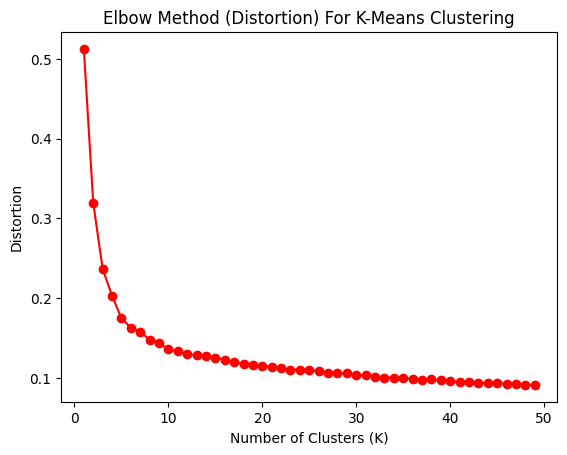

In [10]:
# Elbow Method
from scipy.spatial.distance import cdist

distortions = []
K = range(1, 50)
  
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0, n_init=10).fit(X)
    kmeanModel.fit(X)
  
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    

plt.plot(K, distortions, 'ro-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Distortion')
plt.title('Elbow Method (Distortion) For K-Means Clustering')
plt.show()

In [14]:
kmeans = KMeans(n_clusters=11, random_state=0).fit(X)
print("Cluster Centers: ", kmeans.cluster_centers_)
print("Labels: ", kmeans.labels_)

/home/harin/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster Centers:  [[-1.99451220e-01 -1.75219574e-01 -1.18444683e-01 -2.70401886e-01
  -2.17535183e-01 -2.19452472e-01 -2.32693836e-01]
 [-1.07519587e-03 -5.83469404e-02  1.13073770e-02  1.65770571e-01
   3.00403854e-01  2.54945848e-01 -2.50660211e-03]
 [ 3.59564059e-01  1.07694649e-01  2.34010539e-01  1.20383873e+00
   1.52648909e+00  1.37510181e+00  5.64907142e-01]
 [ 1.32927964e+00  1.40358041e+00  1.02588258e+00  1.55414049e+00
   1.27888958e+00  1.31319523e+00  1.54316765e+00]
 [-9.10521291e-02 -9.80270639e-02 -5.23133812e-02 -1.15190870e-01
  -9.22325220e-02 -8.21350454e-02 -1.09791374e-01]
 [ 5.66251617e-01  5.21436407e-01  3.21300118e-01  5.77899100e-01
   3.65039758e-01  4.08663478e-01  6.19049958e-01]
 [ 2.48051661e-01  1.17018036e-01  1.78012466e-01  5.91491858e-01
   6.91245093e-01  6.25550107e-01  2.98815761e-01]
 [ 1.98555512e+00  2.36301760e+00  2.04913316e+00  2.51649719e+00
   2.31307806e+00  2.38151849e+00  2.41843646e+00]
 [ 2.85585497e-01  2.30660670e-01  1.40027293e

In [15]:
unique, counts = np.unique(kmeans.labels_, return_counts=True)
print("Label Counts: ", dict(zip(unique, counts)))


Label Counts:  {0: 14603, 1: 890, 2: 99, 3: 147, 4: 3427, 5: 719, 6: 425, 7: 32, 8: 1566, 9: 2271, 10: 403}


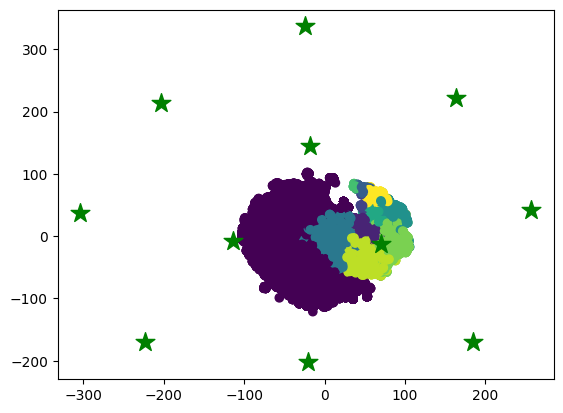

In [16]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=10, random_state=0, learning_rate=300, init='pca')
X_tsne = tsne.fit_transform(X)
cluster_tsne = tsne.fit_transform(kmeans.cluster_centers_)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans.labels_)
plt.scatter(cluster_tsne[:, 0], cluster_tsne[:, 1], marker='*', s=200, c='green')
plt.show()


In [17]:
import umap
standard_embedding = umap.UMAP(random_state=42).fit_transform(X)


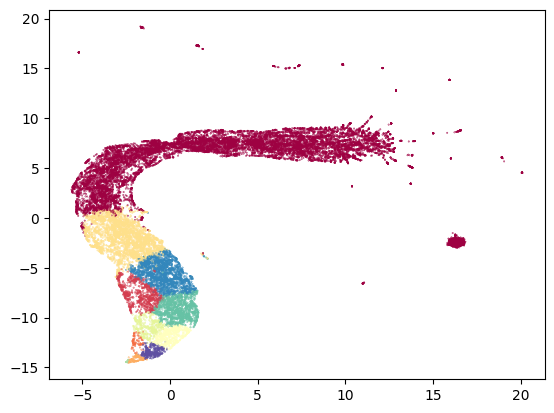

In [18]:
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=kmeans.labels_, s=0.1, cmap='Spectral')

In [19]:
Nociception = ["Ntrk1", "Runx1", "Prdm12", "Th", "Scn10a", "Syt13", "Stra6", "Gal", "Prdm8"]
Mechanoreception1 = ["Pdlim1","Mmd2", "Pou4f3", "Rnf144a"]
Mechanoreception2 = ["Pou6f2", "Dio3", "Onecut3", "Tbx2", "Gpx3", "Ret"]
Proprioception = ["Ntrk3", "Runx3", "Mgst3", "Fam19a4", "Pcp4", "Grm3"]
Fate1 = ["Runx3", "Nfia"]
Fate2 = ["Pou6f2", "Nr5a2", "Hoxb5", "Pdlim1", "Egr1"]
Fate3 = ["Tcf15", "Pdlim1"]
Fate4 = ["Pou6f2", "Onecut3", "Dcc"]

NociceptionCluster = []
Mechanoreception1Cluster = []
Mechanoreception2Cluster = []
ProprioceptionCluster = []
Fate1Cluster = []
Fate2Cluster = []
Fate3Cluster = []
Fate4Cluster = []

for gene in Nociception:
    NociceptionCluster.append(kmeans.labels_[dfParsed[dfParsed["Gene"] == gene].index[0]])

for gene in Mechanoreception1:
    Mechanoreception1Cluster.append(kmeans.labels_[dfParsed[dfParsed["Gene"] == gene].index[0]])

for gene in Mechanoreception2:
    Mechanoreception2Cluster.append(kmeans.labels_[dfParsed[dfParsed["Gene"] == gene].index[0]])

for gene in Proprioception:
    ProprioceptionCluster.append(kmeans.labels_[dfParsed[dfParsed["Gene"] == gene].index[0]])

for gene in Fate1:
    Fate1Cluster.append(kmeans.labels_[dfParsed[dfParsed["Gene"] == gene].index[0]])

for gene in Fate2:
    Fate2Cluster.append(kmeans.labels_[dfParsed[dfParsed["Gene"] == gene].index[0]])
    
for gene in Fate3:
    Fate3Cluster.append(kmeans.labels_[dfParsed[dfParsed["Gene"] == gene].index[0]])

for gene in Fate4:
    Fate4Cluster.append(kmeans.labels_[dfParsed[dfParsed["Gene"] == gene].index[0]])


print("Nociception Cluster: ", NociceptionCluster)
print("Mechanoreception1 Cluster: ", Mechanoreception1Cluster)
print("Mechanoreception2 Cluster: ", Mechanoreception2Cluster)
print("Proprioception Cluster: ", ProprioceptionCluster)
print("Fate1 Cluster: ", Fate1Cluster)
print("Fate2 Cluster: ", Fate2Cluster)
print("Fate3 Cluster: ", Fate3Cluster)
print("Fate4 Cluster: ", Fate4Cluster)

Nociception Cluster:  [2, 0, 1, 1, 4, 6, 1, 4, 0]
Mechanoreception1 Cluster:  [1, 1, 4, 8]
Mechanoreception2 Cluster:  [0, 0, 0, 4, 8, 9]
Proprioception Cluster:  [1, 1, 1, 1, 4, 0]
Fate1 Cluster:  [1, 1]
Fate2 Cluster:  [0, 0, 9, 1, 1]
Fate3 Cluster:  [0, 1]
Fate4 Cluster:  [0, 0, 9]


In [26]:
nociceptionCluster = 1
mechanoreception1Cluster = 1
mechanoreception2Cluster = 0
proprioceptionCluster = 1

nociceptionGenes = dfParsed[kmeans.labels_ == nociceptionCluster]["Gene"].values
mechanoreception1Genes = dfParsed[kmeans.labels_ == mechanoreception1Cluster]["Gene"].values
mechanoreception2Genes = dfParsed[kmeans.labels_ == mechanoreception2Cluster]["Gene"].values
proprioceptionGenes = dfParsed[kmeans.labels_ == proprioceptionCluster]["Gene"].values

# Save to csv
nociceptionGenesDf = pd.DataFrame(nociceptionGenes)
mechanoreception1GenesDf = pd.DataFrame(mechanoreception1Genes)
mechanoreception2GenesDf = pd.DataFrame(mechanoreception2Genes)
proprioceptionGenesDf = pd.DataFrame(proprioceptionGenes)

nociceptionGenesDf.to_csv("./data/kmeansnociceptionGenes.csv")
mechanoreception1GenesDf.to_csv("./data/kmeansmechanoreception1Genes.csv")
mechanoreception2GenesDf.to_csv("./data/kmeansmechanoreception2Genes.csv")
proprioceptionGenesDf.to_csv("./data/kmeansproprioceptionGenes.csv")

# Conclusion

Relatively poor results with K-Means. Even after normalizing data, preprocessing via averages or using a single column, we don't get good clusters.